In [22]:
import math
import numpy as np
import scipy
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from scipy.stats import linregress
from scipy.fft import fft2, fftfreq
from scipy.io import savemat
from tqdm import tqdm

In [23]:
conversions = {
    "length (m)": 1.9732705e-7,
    "mass (kg)": 1.7826627e-36,
    "time (s)": 6.5821220e-16,
    "charge (C)": 1.8755468e-18,
    "electric field (V/m)": 4.3290844e-5,
    "magnetic induction (T)": 1.4440271e-3
}

In [61]:
num_points = 10000
e = 8.5424546e-2 # = 1.60217733e-19 C
c = 1 # = 2.99792458e8 m/s
m = 5.1099906e5 # m_e = 9.1093897e-31 kg
E = np.array([0, 0, 0]) # = 0 V/m
B = np.array([1, 0, 0])/conversions["magnetic induction (T)"] # = 1 Tesla
t_span = (0, 1e-6/conversions["time (s)"]) # = 1 us
p0 = np.array([100e6, 100e6, 100e6]) # = 100 MeV
r0 = np.array([0, 0, 0]) # = 0 m
rtol = 1e-5 # = 0.001%
p_atol = 1*m/num_points
r_atol = c*t_span[1]/num_points
atol = np.array([p_atol, p_atol, p_atol, r_atol, r_atol, r_atol])
t_eval = np.linspace(*t_span, num_points) # 10000 points inside t_span

In [70]:
def gamma(p):
    p2 = np.dot(p, p)
    return math.sqrt(1 + p2/(m**2 * c**2))
def lorentz(v):
    return e * (E + np.cross(v, B) / c)
def g0(v, l, gv):
    return v * gv**2 / m**2 / c**6 * np.dot(v, v) * [np.dot(l, l) - e**2 * np.dot(v, E)**2]
def fun(t, y):
    p, r = np.split(y, 2)
    gv = gamma(p)
    v = p / (m * gv)
    l = lorentz(v)
    g = g0(v, l, gv)
    dpdt = l - 2/3 * e**2 / c * g
    drdt = v
    return np.concatenate([dpdt, drdt])
def plot3D(ax, u, c, prefix, suffix):
    x, y, z = u
    sc = ax.scatter(x, y, z, c=c, cmap="hot", marker=".", s=1)
    plt.colorbar(sc, ax=ax, location="bottom", shrink=0.5, pad=0.01, label="t (s)")
    ax.set_xlabel(prefix + "x" + suffix)
    ax.set_ylabel(prefix + "y" + suffix)
    ax.set_zlabel(prefix + "z" + suffix)
    return ax
def run(fun, t, y, progress):
    progress.n = t
    progress.update(0)
    return fun(t, y)

In [71]:
y0 = np.concatenate([p0, r0])
with tqdm(total=t_span[1], position=t_span[0]) as progress:
    sol = solve_ivp(lambda t, y: run(fun, t, y, progress), t_span, y0, method="RK45", t_eval=t_eval, dense_output=True, rtol=rtol, atol=atol)

100%|██████████████████████████████████████████| 1519266886.8793375/1519266886.8793375 [00:00<00:00, 2737092961.78it/s]


In [72]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 5702
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000001C91A009130>
   status: 0
  success: True
        t: array([0.00000000e+00, 1.51941883e+05, 3.03883766e+05, ...,
       1.51896300e+09, 1.51911494e+09, 1.51926689e+09])
 t_events: None
        y: array([[ 1.00000000e+08,  9.99999996e+07,  9.99999991e+07, ...,
         9.99956402e+07,  9.99956398e+07,  9.99956394e+07],
       [ 1.00000000e+08,  1.05052515e+08,  1.09822207e+08, ...,
        -9.64439638e+07, -9.09912759e+07, -8.52914452e+07],
       [ 1.00000000e+08,  9.46782404e+07,  8.91015474e+07, ...,
         1.02130285e+08,  1.07016674e+08,  1.11612401e+08],
       [ 0.00000000e+00,  8.77233106e+04,  1.75446663e+05, ...,
         8.78919786e+08,  8.79007900e+08,  8.79096015e+08],
       [ 0.00000000e+00,  8.99596751e+04,  1.84228778e+05, ...,
        -3.60103237e+04, -1.18610458e+05, -1.962971

In [73]:
t_sol = sol.t
y_sol = sol.y
p_sol, r_sol = np.split(y_sol, 2)

In [144]:
t = 6.5821220e-16 * t_sol # in s
p = p_sol * 5.3442883e-28 # in kg * m/s
v = p_sol / m * 2.99792458e8 # in m/s
r = r_sol * 1.9732705e-7 # in m
r_corr_sol = r_sol - np.tile(np.mean(r_sol, axis=1), (r_sol.shape[1],1)).T
r_corr = r_corr_sol * 1.9732705e-7 # in m
v_corr = v - np.tile(np.mean(v, axis=1), (v.shape[1],1)).T
omega = np.cross(r_corr, v_corr, axis=0)/np.linalg.norm(r_corr[1:], axis=0)**2

<Axes3DSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

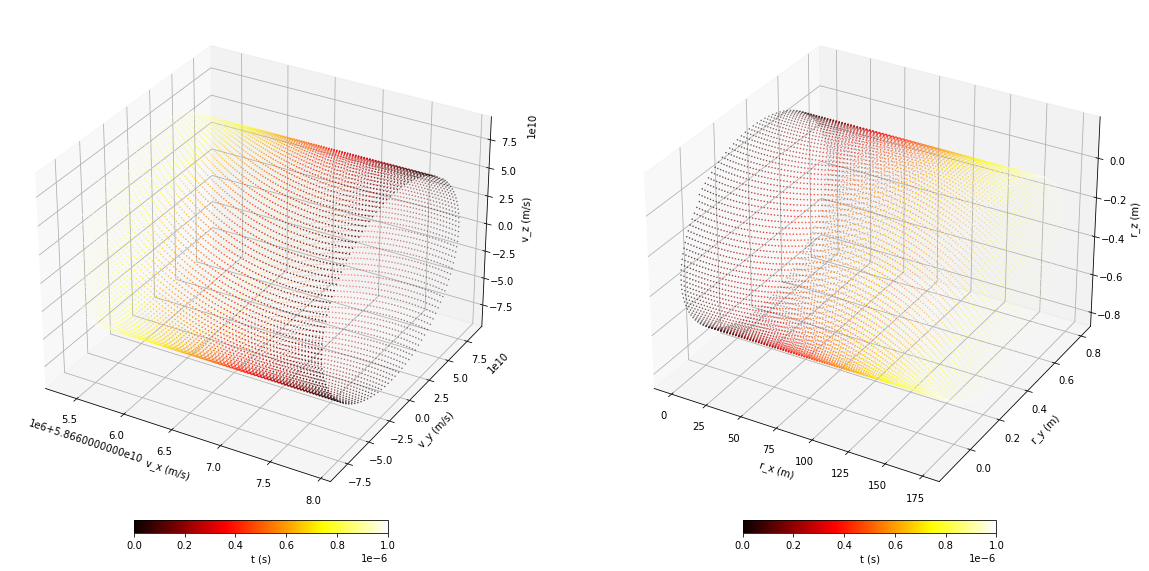

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(20, 12), subplot_kw=dict(projection="3d"))
plot3D(axs[0], v, t, "v_", " (m/s)")
plot3D(axs[1], r, t, "r_", " (m)")

Text(0.5, 0, 't (s)')

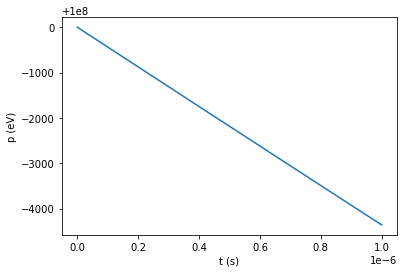

In [163]:
plt.plot(t, np.linalg.norm(p_sol[:1], axis=0))
plt.ylabel("p (eV)")
plt.xlabel("t (s)")

Text(0.5, 0, 't (s)')

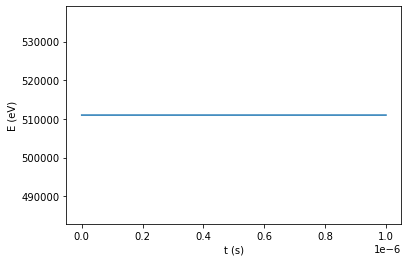

In [164]:
energy = np.sqrt(np.linalg.norm(p, axis=0)**2 * c**2 + (m * c**2)**2)
plt.plot(t, energy)
plt.ylabel("E (eV)")
plt.xlabel("t (s)")

Text(0.5, 0, 't (s)')

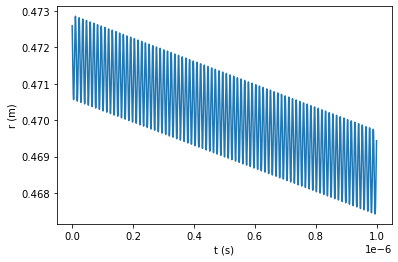

In [153]:
plt.plot(t, np.linalg.norm(r_corr[1:], axis=0))
plt.ylabel("r (m)")
plt.xlabel("t (s)")

Text(0.5, 0, 't (s)')

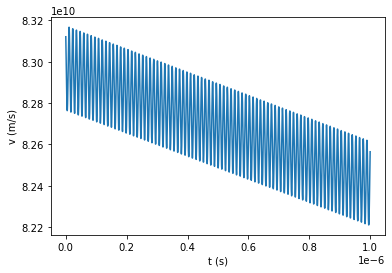

In [148]:
plt.plot(t, np.linalg.norm(v_corr[1:], axis=0))
plt.ylabel("v (m/s)")
plt.xlabel("t (s)")

Text(0.5, 0, 't (s)')

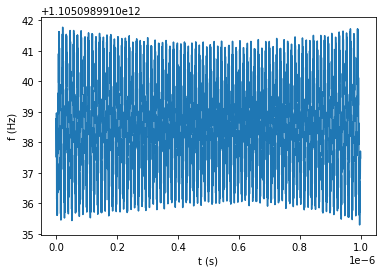

In [150]:
f = 2 * np.pi * np.linalg.norm(omega[:1], axis=0)
plt.plot(t, f)
plt.ylabel("f (Hz)")
plt.xlabel("t (s)")

Text(0.5, 0, 't (s)')

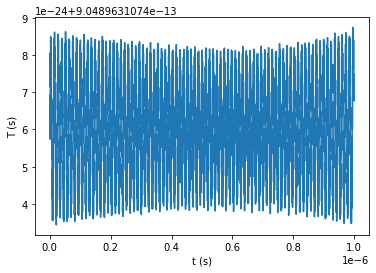

In [151]:
T = 1/f
plt.plot(t, T)
plt.ylabel("T (s)")
plt.xlabel("t (s)")

In [ ]:
plt.plot(t, np.linalg.norm(omega, axis=0))
plt.ylabel("ω (rad/s)")
plt.xlabel("t (s)")

In [ ]:
plt.figure(figsize=(7.6,10))
plt.scatter(*r[1:], marker=".", c=t, cmap="hot", s=10)
plt.xlabel("r_y (m)")
plt.ylabel("r_z (m)")
plt.colorbar(location="bottom", pad=0.1, label="t (s)")

In [ ]:
plt.figure(figsize=(7.6,10))
plt.scatter(*v[1:], marker=".", c=t, cmap="hot", s=10)
plt.xlabel("v_y (m)")
plt.ylabel("v_z (m)")
plt.colorbar(location="bottom", pad=0.1, label="t (s)")

In [ ]:
set up seperate files
units new gamma formula
wind power of radiative friction